In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from pathlib import Path
from dynamiqs import wigner
import jax.numpy as jnp
import dynamiqs as dq
import scipy.optimize as spo

In [2]:
def load_and_visualize_states(file_path):
    """
    Loads a Quantum-State-Pickle file and visualize the corresponding Wigner function
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"\nLade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            wigner_function = wigner(state)
            plt.contourf(wigner_function[0], wigner_function[1], wigner_function[2],levels=100, cmap='seismic', vmax=np.pi/2, vmin=-np.pi/2)
            plt.colorbar()
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [3]:
def compute_wigner_function(file_path):
    """
    Lädt alle Quantum-State Pickle-Dateien aus dem angegebenen Verzeichnis und visualisiert sie.
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"Lade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            wigner_function = wigner(state)
            return wigner_function
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [4]:
file_path = "../../../data/synthetic/quantum_state_1.pickle"
load_and_visualize_states(file_path) 

Verzeichnis ../../../data/synthetic/quantum_state_1.pickle existiert nicht!


In [5]:
# Compute the Wigner function
file_path = "../../../data/synthetic/quantum_state_1.pickle"
wigner_fct = compute_wigner_function(file_path) 

Verzeichnis ../../../data/synthetic/quantum_state_1.pickle existiert nicht!


In [6]:
def uniform_displacement_sampling(wigner_fct, n_samples=200, threshold_factor=0.2):
    """
    Performs uniform sampling of the Wigner function.
    
    Parameters:
    -----------
    wigner_fct : tuple
        The Wigner function as a tuple (x_grid, p_grid, w_values)
    n_samples : int
        Number of points to sample
    threshold_factor : float
        Factor for threshold values
        
    Returns:
    --------
    alpha_k : numpy.ndarray
        Complex values of the sampled points
    alpha_k_x : numpy.ndarray
        x-components of the sampled points
    alpha_k_p : numpy.ndarray
        p-components of the sampled points
    """
    # Find the maximum of the Wigner function
    max_value = np.max(wigner_fct[2])
    max_pos = np.where(wigner_fct[2] == max_value)  
    x_max = wigner_fct[0][max_pos[0][0]] 
    p_max = wigner_fct[1][max_pos[1][0]]
    print(f"Maximum der Wigner-Funktion: {max_value}")
    print(f"Position des Maximums: x = {x_max}, p = {p_max}")

    # Shift the grid
    x_grid = wigner_fct[0] - x_max
    p_grid = wigner_fct[1] - p_max
    wigner_fct_shifted = (x_grid, p_grid, wigner_fct[2])

    # Find the minimum of the Wigner function
    min_value = np.min(wigner_fct[2])
    min_pos = np.where(wigner_fct[2] == min_value)  
    x_min = wigner_fct[0][min_pos[0][0]] 
    p_min = wigner_fct[1][min_pos[1][0]]
    print(f"Minimum der Wigner-Funktion: {min_value}")
    print(f"Position des Minimums: x = {x_min}, p = {p_min}")

    # Define thresholds
    threshold_max = threshold_factor * max_value  
    threshold_min = threshold_factor * min_value - 0.1

    # Create mask for sampling
    mask = (wigner_fct_shifted[2] >= threshold_max) | (wigner_fct_shifted[2] <= threshold_min)
    rows, cols = np.where(mask)
    x_sampled = x_grid[rows]
    p_sampled = p_grid[cols]
    w_sampled = wigner_fct_shifted[2][mask]

    # Uniformes Sampling
    indices = np.random.choice(len(x_sampled), n_samples, replace=False)
    alpha_k_x = x_sampled[indices]
    alpha_k_p = p_sampled[indices]

    print(f"Number of points sampled: {len(alpha_k_x)}")
    
    alpha_k = [(x.item(), p.item()) for x, p in zip(alpha_k_x, alpha_k_p)]
    return alpha_k

In [7]:
def radial_displacement_sampling(wigner_fct, n_samples=200, threshold_factor=0.2):
    """
    Performs radial sampling of the Wigner function. We draw the x and p coordinates both independently from a normal distribution
    
    Parameters:
    -----------
    wigner_fct : tuple
        The Wigner function as a tuple (x_grid, p_grid, w_values)
    n_samples : int
        Number of points to sample
    threshold_factor : float
        Factor for threshold values
        
    Returns:
    --------
    alpha_k : numpy.ndarray
        Complex values of the sampled points
    alpha_k_x : numpy.ndarray
        x-components of the sampled points
    alpha_k_p : numpy.ndarray
        p-components of the sampled points
    """
    # Find the maximum of the Wigner function
    max_value = np.max(wigner_fct[2])
    max_pos = np.where(wigner_fct[2] == max_value)  
    x_max = wigner_fct[0][max_pos[0][0]] 
    p_max = wigner_fct[1][max_pos[1][0]]
    print(f"Maximum der Wigner-Funktion: {max_value}")
    print(f"Position des Maximums: x = {x_max}, p = {p_max}")

    # Shift the grid
    x_grid = wigner_fct[0] - x_max
    p_grid = wigner_fct[1] - p_max
    wigner_fct_shifted = (x_grid, p_grid, wigner_fct[2])

    # Find the minimum of the Wigner function
    min_value = np.min(wigner_fct[2])
    min_pos = np.where(wigner_fct[2] == min_value)  
    x_min = wigner_fct[0][min_pos[0][0]] 
    p_min = wigner_fct[1][min_pos[1][0]]
    print(f"Minimum der Wigner-Funktion: {min_value}")
    print(f"Position des Minimums: x = {x_min}, p = {p_min}")

    # Define thresholds
    threshold_max = threshold_factor * max_value  
    threshold_min = threshold_factor * min_value - 0.1

    # Create mask for sampling
    mask = (wigner_fct_shifted[2] >= threshold_max) | (wigner_fct_shifted[2] <= threshold_min)
    rows, cols = np.where(mask)
    x_sampled = x_grid[rows]
    p_sampled = p_grid[cols]
    w_sampled = wigner_fct_shifted[2][mask]

    # Uniformes Sampling
    indices = np.random.choice(len(x_sampled), n_samples, replace=False)
    alpha_k_x = x_sampled[indices]
    alpha_k_p = p_sampled[indices]

    print(f"Number of points sampled: {len(alpha_k_x)}")
    
    alpha_k = [(x, p) for x, p in zip(alpha_k_x, alpha_k_p)]
    return alpha_k

In [8]:
N = 20

def cat_factory(n, alpha=1):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)
    
    return cat_n / cat_n.norm()

def cat_dm_factory(n, alpha=1):
    return cat_factory(n, alpha=alpha).todm()

def plot_wigner(xvals, yvals, wigner_values):
    plt.contourf(xvals, yvals, wigner_values.T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
    plt.colorbar()

In [9]:
N = 20
state = dq.fock(N, 1)
wigner_fct = dq.wigner(state)

xvec, yvec, wig = wigner_fct

# plot_wigner(xvec, yvec, wig)

aks = radial_displacement_sampling(wigner_fct)

Maximum der Wigner-Funktion: 0.2840973138809204
Position des Maximums: x = -0.720000147819519, p = -0.4800001382827759
Minimum der Wigner-Funktion: -0.6366197466850281
Position des Minimums: x = 0.0, p = 0.0
Number of points sampled: 200


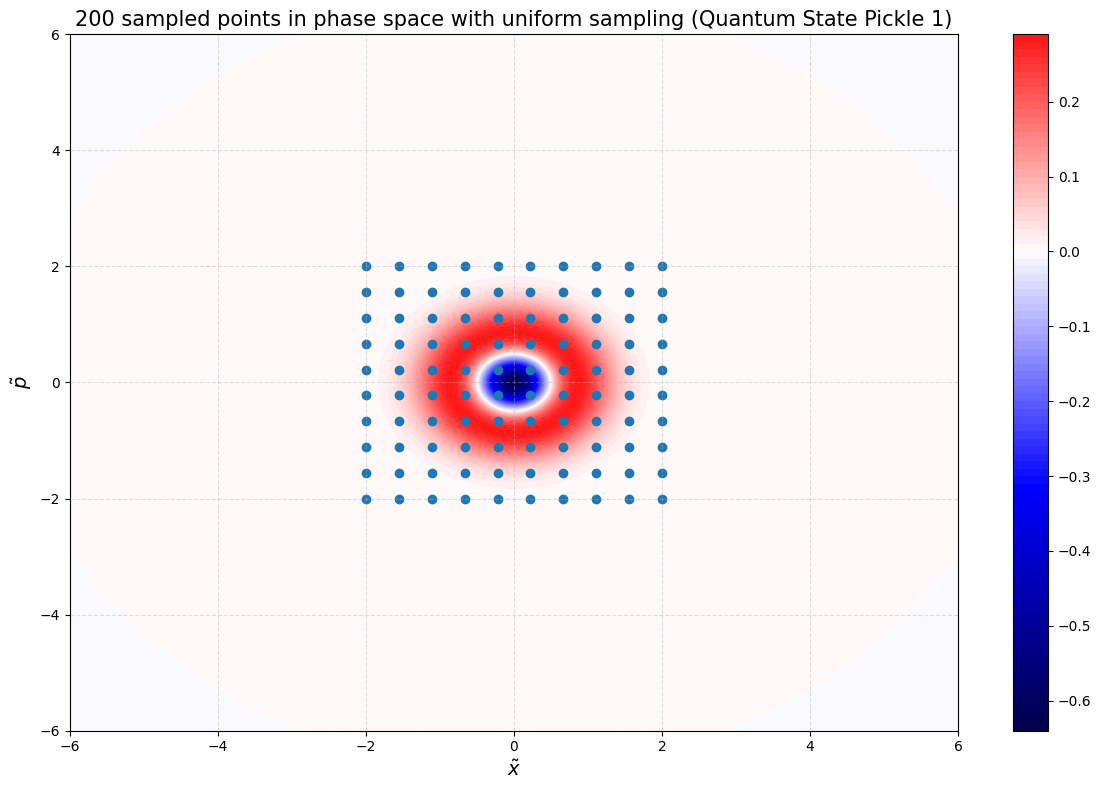

In [29]:
N = 20
state = dq.fock(N, 1)
# state = cat_factory(2)
wigner_fct = dq.wigner(state)

# Scatterplot of the selected points
plt.figure(figsize=(12, 8))
# Extrahiere x und p Komponenten aus alpha_k
alpha_k_x = [point[0] for point in dumb_sampling(xlims=(-2,2), ylims=(-2,2))]
alpha_k_p = [point[1] for point in dumb_sampling(xlims=(-2,2), ylims=(-2,2))]
plt.contourf(wigner_fct[0], wigner_fct[1], wigner_fct[2].T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
plt.colorbar()
plt.scatter(alpha_k_x, alpha_k_p)
plt.xlabel(r"$\tilde{x}$", fontsize=14)
plt.ylabel(r"$\tilde{p}$", fontsize=14)
plt.title("200 sampled points in phase space with uniform sampling (Quantum State Pickle 1)", fontsize=15)
#plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
# plt.savefig('../../../images/200_uniformsampled_points_phase_space.png', dpi=300, bbox_inches='tight')

plt.show()

In [11]:
def get_measurement_probabilities(xvec, yvec, wigner, alpha_ks):
    w_ks = []
    for alpha_k in alpha_ks:
        xi = jnp.abs(xvec - alpha_k[0]).argmin()
        yi = jnp.abs(yvec - alpha_k[1]).argmin()
        w_ks += [1/2 * (1 + jnp.pi/2 * wigner[xi, yi])]
    return w_ks

In [12]:
def get_measurement_operators(N, alpha_ks):
    Eks = []
    for alpha_k in alpha_ks:
        alpha_z = alpha_k[0] + 1j* alpha_k[1]
        a=dq.destroy(N)
        D = lambda alph: dq.expm(alph*a.dag() - alph.conjugate()*a)
        P = dq.expm(1j*jnp.pi*a.dag()@a)
        E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())
        Eks += [E]
    return Eks

In [13]:
def fit_density_matrix(w_k, E_alpha_k, N):
    """
    Fits a density matrix using convex optimization.
    
    Parameters:
    -----------
    w_k : array-like
        List of observed measurement values
    E_alpha_k : array-like
        Measurement operators
    N : int
        Dimension of the density matrix
        
    Returns:
    --------
    rho_optimal : numpy.ndarray
        The optimized density matrix
    """
    K = len(w_k)
    
    # Define the variable for the density matrix
    rho = cp.Variable((N, N), symmetric=True)
    
    # Define the objective function using least-squares error
    #objective = cp.Minimize(jnp.sum(jnp.array((jnp.real((cp.trace(E_alpha_k[k] @ rho))) - w_k[k])**2 for k in range(K))))
    #squared_differences = jnp.array([jnp.square(jnp.real(cp.trace(E_alpha_k[k] @ rho)) - w_k[k]) for k in range(K)])

    # Berechne die Summe der quadrierten Differenzen
    #objective = cp.Minimize(jnp.sum(squared_differences))

    trace_values = jnp.array([jnp.real(dq.trace(E_alpha_k[k] @ rho)) for k in range(K)])

    # Jetzt kannst du die Differenzen berechnen und in ein JAX-Array umwandeln
    squared_differences = jnp.array([jnp.square(val - w_k[k]) for k, val in enumerate(trace_values)])

    # Berechne die Summe der quadrierten Differenzen
    objective = cp.Minimize(jnp.sum(squared_differences))

    # Define the two constraints for the density matrix
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Formulate and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return rho.value

In [18]:
# Develop dumb_sampling

nx, ny = 10, 10
xlims = (-6,6)
ylims = (-6,6)

xlist = np.linspace(xlims[0], xlims[1], nx)
ylist = np.linspace(ylims[0], ylims[1], ny)

alpha_ks = [(xv, yv) for yv in ylist for xv in xlist]

len(alpha_ks)


100

In [20]:
def dumb_sampling(nx=10, ny=10, xlims=(-6,6), ylims=(-6,6)):
    xlist = np.linspace(xlims[0], xlims[1], nx)
    ylist = np.linspace(ylims[0], ylims[1], ny)

    alpha_ks = [(xv, yv) for yv in ylist for xv in xlist]
    return alpha_ks

In [34]:
# Develop dumb_fit_density_matrix()
N = 20

# file_path = "../../data/synthetic/quantum_state_1.pickle"
# wigner_fct = compute_wigner_function(file_path) 

with open("../../data/synthetic/noisy_wigner_5.pickle", 'rb') as f:
    wigner_fct = pickle.load(f)


alpha_ks = dumb_sampling()
wks = get_measurement_probabilities(wigner_fct[0], wigner_fct[1], wigner_fct[2], alpha_ks)
Eks = get_measurement_operators(N, alpha_ks)


loss_func = lambda rho: jnp.sum(np.array([jnp.square(jnp.abs(dq.trace(Eks[k] @ rho.reshape((N,N))) - wks[k])) for k in range(len(wks))]))

rho_init = dq.to_numpy(dq.fock_dm(N, 1))
rho_init_flat = rho_init.flatten()

res = spo.minimize(loss_func, rho_init_flat)



/home/manman/.local/lib/python3.10/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
/tmp/ipykernel_191550/399408496.py:8: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())
/home/manman/.local/lib/python3.10/site-packages/scipy/_lib/array_api_compat/common/_aliases.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)


In [32]:
compute_wigner_function(file_path)

Lade Datei: ../../data/synthetic/quantum_state_1.pickle
Fehler beim Verarbeiten von ../../data/synthetic/quantum_state_1.pickle: 'jaxlib.xla_extension.ArrayImpl' object is not callable


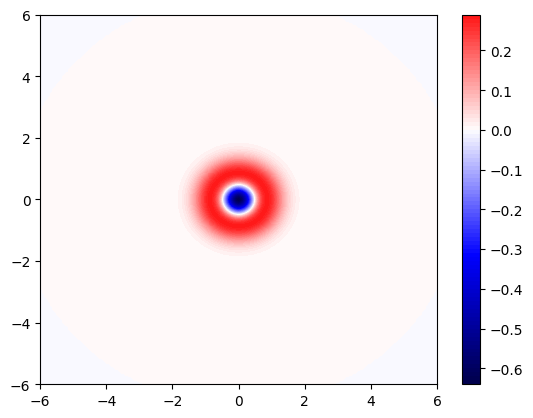

In [36]:
xvals, yvals, wigner = dq.wigner(res.x.reshape((N,N)))
plot_wigner(xvals, yvals, wigner)
# plot_wigner(wigner_fct[0], wigner_fct[1], wigner_fct[2])

In [49]:
rhot_notflat

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [ ]:
def dumb_fit_density_matrix(w_k, E_alpha_k, N):
    return

In [14]:
# Dimension of the density matrix
N = 20
#xvec, yvec, wigner = dq.wigner(dq.fock(N, 1))
#alpha_ks = [(1,1), (1,-1), (-1,-1), (-1,1)]

file_path = "../../../data/synthetic/quantum_state_1.pickle"
wigner_fct = compute_wigner_function(file_path) 

alpha_ks = uniform_displacement_sampling(wigner_fct, 100, 0.2)
wks = get_measurement_probabilities(wigner_fct[0], wigner_fct[1], wigner_fct[2], alpha_ks)
Eks = get_measurement_operators(N, alpha_ks)

rho_optimal = fit_density_matrix(wks, Eks, N)

print("W_k list:")
print(wks)

print("Eks:")
print(Eks)

print("Optimal density matrix ρ:")
print(rho_optimal)

Verzeichnis ../../../data/synthetic/quantum_state_1.pickle existiert nicht!


TypeError: 'NoneType' object is not subscriptable